### 1. Neural Network Classification 

In [60]:
import torch
import sklearn 
from torch import nn

In [61]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000 

# Make circles
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)

In [62]:
len(X), len(y)

(1000, 1000)

In [63]:
print(f"First 5 samples of X:\n{X[:5]}")
print(f"First 5 samples of y \n{y[:5]}")

First 5 samples of X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y 
[1 1 1 1 0]


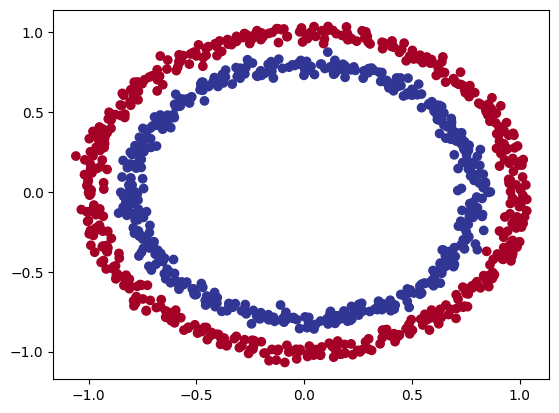

In [64]:
import matplotlib.pyplot as plt
# Visualizing
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu)

#### Checking Input and Output Shapes 

In [65]:
X.shape, y.shape

((1000, 2), (1000,))

In [66]:
# View the first example of features and labels 
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


#### Turning data into Tensors and creating training and testing splits 

In [67]:
# Turn data into tensors 
import torch
type(X)

numpy.ndarray

In [68]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [69]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [70]:
# Splitting into training and testing set 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                  y,
                                                  test_size = 0.2, # meaning test size is 20%
                                                  random_state = 42)

# Remember that the n_samples we chose was 1000 so 20% should be 200 for the test set. 

#### Building a model

Let's build a model to classify our blue and red dots 

To do so,  we want to: 
1. Setup device-agnostic code so our code will run on our GPU
2. Construct a model by subclassing `nn.module`
3. Define loss function and optimizer
4. Creating a training and test loop

In [71]:
# Make device agnostic code. 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we've set up device-agonistic code, lets create a model that: 
1. Subclasses `nn.module` (almost all models in PyTorch subclass `nn.module`)
2. Create 2 `nn.Linear()` Layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model 
4. Instantiate an instance of our model class and send it to our device. 

In [72]:
# 1. Construct a model that sublcasses nn.module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features = 2, out_features = 5) # takes in 2 features and upscales to 5 features
        self.layer_2 = nn.Linear(in_features = 5, out_features = 1) # takes in the 5 features and outputs the same shape as y

    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer1 -> layer2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0  


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [73]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [74]:
# Replicating the model using nn.Sequencial
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [75]:
# Make predictions
with torch.inference_mode():
    untrained_pred = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_pred)}, Shape: {untrained_pred.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_pred[:10]}")
print(f"\nFirst 10 labels: \n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[0.0763],
        [0.1453],
        [0.0813],
        [0.0742],
        [0.3760],
        [0.4158],
        [0.3764],
        [0.4404],
        [0.0688],
        [0.1532]], device='cuda:0')

First 10 labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


#### Setup Loss Function and Optimizer

Which loss function or optimizer should I use? 
(This is problem specific)
* For Regression we might use MSE or MAE 
* For Classification we'd want something like Binary Cross Entropy or Categorical Cross Entropy

Reminder: The loss function measures how wrong the models predictions are. Thus we want to minimize our loss function such that our model is predicting correctly as much as possible. 

* Cross Entropy Loss is usually for multi-class classification (Computer Vision and stuff like that)
The others are for binary classification. 


For Optimizers 
* SGD or Adam are very popular in PyTorch


For this specific problems we're going to use `torch.nn.BCEWithLogitsLoss()` as our loss function. BCE is Binary Cross Entropy Loss 
* For different optimizers see `torch.optim` documentation.

In [76]:
# Setup Loss Function 
# loss_fn = torch.nn.BCELoss() Requires input to have gone through the sigmoid activation function prior to passing it through this.
# nn.Sequential(nn.Sigmoid(), nn.BCELoss())
# Like this ^

loss_fn = torch.nn.BCEWithLogitsLoss() # this has the sigmoid function built in, for binary classification we need to include a sigmoid function. For multiclass classification we need the softmax.
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.1)

In [77]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc 

#### Training the model

To train our model, we're going to need to build a training loop with the following steps: 

1. Forward pass 
2. Calculate the loss 
3. Optimizer zero gradient
4. Loss backward (backpropagation)
5. Optimizer step  (gradient descent)

##### Going from raw logits -> prediction probabilities -> prediction labels
Our model ouputs are going to be raw **logits**. 
We can convert these **logits** into prediction probabilities by passing the mto some kind of activation function (e.g sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.





In [78]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.0763],
        [0.1453],
        [0.0813],
        [0.0742],
        [0.3760]], device='cuda:0')

In [79]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [80]:
# Use the sigmoid activation function on our model logits to turn them into predict ion probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5191],
        [0.5363],
        [0.5203],
        [0.5185],
        [0.5929]], device='cuda:0')

For our prediction probabilities values, we need to perform a range-style rounding on them: 
* `y_pred_probs` >= 0.5, `y=1` (class = 1)
* `y_pred_probs` < 0.5, `y=0` (class=0)

In [81]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension 
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

In [82]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

#### Building a training and test loop

In [83]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    # Training
    model_0.train()

    # 1. Forward Pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculating loss/accuracy 
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                   y_train)
    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing 
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)
        
        # Printing out what is happening
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
    

Epoch: 0 | Loss: 0.70234, Acc: 57.38% | Test loss: 0.70194, Test acc: 57.00%
Epoch: 10 | Loss: 0.69697, Acc: 52.75% | Test loss: 0.69803, Test acc: 54.00%
Epoch: 20 | Loss: 0.69505, Acc: 51.62% | Test loss: 0.69667, Test acc: 51.00%
Epoch: 30 | Loss: 0.69427, Acc: 51.12% | Test loss: 0.69607, Test acc: 51.00%
Epoch: 40 | Loss: 0.69390, Acc: 50.38% | Test loss: 0.69572, Test acc: 49.50%
Epoch: 50 | Loss: 0.69367, Acc: 50.50% | Test loss: 0.69547, Test acc: 49.00%
Epoch: 60 | Loss: 0.69352, Acc: 50.38% | Test loss: 0.69526, Test acc: 49.00%
Epoch: 70 | Loss: 0.69341, Acc: 50.50% | Test loss: 0.69509, Test acc: 49.00%
Epoch: 80 | Loss: 0.69333, Acc: 50.38% | Test loss: 0.69495, Test acc: 49.00%
Epoch: 90 | Loss: 0.69326, Acc: 50.25% | Test loss: 0.69483, Test acc: 48.50%


#### Make predictions and evaluate the model 

From the metrics it looks like our model isn't learning anything... 

So to inspect it let's make some predictions and make them visual!

In other words, lets Visualize it

To do so, we're going to import a function called `plot_decision_boundary()`

In [84]:
import requests 
from pathlib import Path

# Download helper function from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else: 
    print("Download helper_function.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(requests.content)

# some reason helper function isn't downloading correctly

helper_functions.py already exists, skipping download


#### Improving our model (from model perspective)

* Add more layers - give the model more chances to to learn about the data. 
* Add more hidden units - go from 5 hidden units to 10 hidden units. 
* Fit for longer - adding more epochs
* Changing the activation functions 
* Change the learning rate 
* Change the loss function 

These are all options from the models perspective because they deal directly with the model, rather than the data. 

And since these are values that we can physically change, they're called **hyperparameters** (RECALL hyperparameter tuning in the ALL-STAR project)

Let's try improving our model by 
* Addiing more hidden units 5 -> 10
* Increase the number of layers 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [85]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations is quicker than writing each line one by one.
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [86]:
# Create a Loss Function
loss_fn = nn.BCEWithLogitsLoss()
# Create an Optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.1)

In [87]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer 
epochs = 1000
# put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # Training
    model_1.train()

    # 1. Forward pass 
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred prob -> pred labels

    # 2. Calculate the loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred = y_pred)
    
    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # Loss backwards (backpropogation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass 
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate Loss 
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred = test_pred)
        
        # Print out whats happening
        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")


Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test loss: 0.69379, Test acc: 48.00
Epoch: 200 | Loss: 0.69299, Acc: 51.12% | Test loss: 0.69437, Test acc: 46.00
Epoch: 300 | Loss: 0.69298, Acc: 51.62% | Test loss: 0.69458, Test acc: 45.00
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69465, Test acc: 46.00
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69467, Test acc: 46.00
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00


We would plot the decision boundary but the helper function isn't working and im too lazy to make a new function for it. 

#### Preparing data to see if our model can fit a straight line

One way to troubleshoot a larger problem is to test out a smaller problem

In [88]:
# Create some data

weight = 0.7
bias = 0.3 
start = 0 
end = 1
step = 0.01

# Create data 
X_regression = torch.arange(start, end, step).unsqueeze(dim = 1)
y_regression = weight * X_regression + bias # Linear regression 

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [89]:
# Create train and test split 
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

#### Non-linarity in NNs 

In [90]:
from torch import nn 
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() 

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

### Putting it all together in a multiclass problem. 

So far we've only done regression and binary classification problems. 

Now we can try classifying things that fall under multiple categories. 

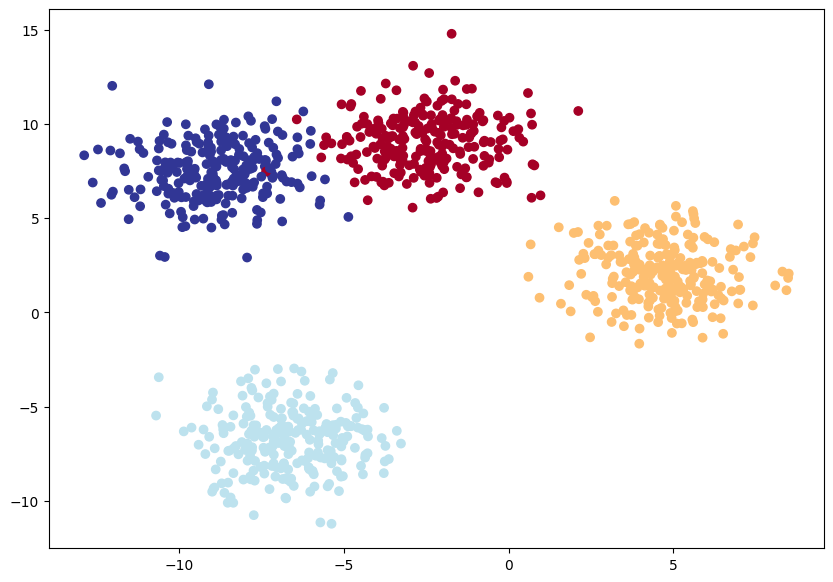

In [91]:
# importing dependencies 
import torch 
import matplotlib.pyplot as plt 
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split 

# Set the hyperparameters for data creation 
NUM_CLASSES = 4
NUM_FEATURES =  2 
RANDOM_SEED = 42 

# 1. Create multi-class data 
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std =  1.5, # give the clusters a bit of variation
                            random_state = RANDOM_SEED)

# 2. Turnm data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, 
                                                                        y_blob, 
                                                                        test_size = 0.2,
                                                                        random_state = RANDOM_SEED)

# 4. Plot data 
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

#### Building a mutliclass classification model in PyTorch


In [92]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        """ Initializes multi-class classification model.

        Args: 
            input features (int): Number of input features to the model
            output features(int): Number of output features (number of output classes)
            hidden units (int): Number of hidden units between layers, defaults 8

        Returns: 
        Examples:
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features= output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
    
# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features = 2,
                    output_features = 4,
                    hidden_units = 8).to(device)


#### Create a loss function and Optimizer for multiclass model

In [93]:
# Create loss function for multi class
loss_fn = nn.CrossEntropyLoss()

# Create and optimizer 
optimizer = torch.optim.SGD(params = model_4.parameters(),
                            lr = 0.01)

#### Getting prediction probs for a PyTorch multiclass model

In order to evaluate and train and test the model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels. 

Logits (raw output of the model) -> pred probs (use `torch.softmax`) -> Pred labels (take the argmax of the prediction probabilites)

In [94]:
# Getting raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

y_preds[:10]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')

In [95]:
# Convert our model's logit outputs to prediction probs 
y_pred_probs = torch.softmax(y_logits, dim = 1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.4603,  0.1242, -0.1447,  0.2262],
        [-0.3816,  0.7560,  1.3547,  1.3346],
        [-0.4090,  0.1508, -0.2864, -0.2967],
        [-0.3858, -0.0221, -0.1996,  0.0551],
        [-0.3900,  0.3935,  0.9896,  1.2713]], device='cuda:0')
tensor([[0.1626, 0.2916, 0.2229, 0.3230],
        [0.0651, 0.2031, 0.3696, 0.3622],
        [0.2000, 0.3501, 0.2261, 0.2238],
        [0.1924, 0.2768, 0.2318, 0.2990],
        [0.0805, 0.1761, 0.3197, 0.4237]], device='cuda:0')


In [96]:
# Convert our model's prediction probabilites to prediction labels
y_preds = torch.argmax(y_pred_probs, dim = 1)
y_preds


tensor([3, 2, 1, 3, 3, 2, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 2, 1, 2, 2, 3, 3, 3, 1,
        1, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3, 1, 3, 2, 3, 1, 3, 2, 2, 1, 3, 3, 3, 3,
        3, 2, 3, 3, 3, 3, 2, 1, 3, 3, 2, 1, 1, 3, 2, 1, 1, 3, 3, 3, 2, 3, 3, 3,
        2, 2, 1, 2, 2, 2, 3, 3, 3, 1, 3, 1, 2, 2, 1, 2, 2, 1, 2, 2, 3, 2, 2, 2,
        3, 3, 2, 1, 3, 3, 3, 3, 1, 2, 3, 3, 3, 1, 3, 3, 3, 1, 1, 2, 3, 3, 3, 1,
        1, 2, 3, 3, 1, 3, 3, 3, 1, 2, 3, 1, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 1, 1,
        1, 1, 3, 2, 3, 1, 1, 3, 2, 1, 3, 3, 2, 2, 1, 3, 1, 3, 2, 1, 3, 2, 1, 3,
        1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 3,
        3, 2, 1, 3, 2, 3, 1, 3], device='cuda:0')

In [97]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model 

In [98]:
# Fit the multiclass model to the data 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100 

# Put data to the target device 
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
    # Training 
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred = y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim = 1).argmax(dim = 1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_pred = test_pred)
        
        # Print out 
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.58554, Acc: 5.25% | Test loss: 1.52451, Test acc: 22.50%
Epoch: 10 | Loss: 1.35796, Acc: 24.25% | Test loss: 1.31117, Test acc: 22.50%
Epoch: 20 | Loss: 1.24466, Acc: 24.25% | Test loss: 1.20831, Test acc: 22.50%
Epoch: 30 | Loss: 1.17784, Acc: 24.50% | Test loss: 1.14649, Test acc: 22.50%
Epoch: 40 | Loss: 1.13077, Acc: 28.38% | Test loss: 1.10257, Test acc: 22.50%
Epoch: 50 | Loss: 1.09699, Acc: 43.25% | Test loss: 1.07055, Test acc: 22.50%
Epoch: 60 | Loss: 1.07152, Acc: 48.50% | Test loss: 1.04592, Test acc: 22.50%
Epoch: 70 | Loss: 1.05106, Acc: 48.50% | Test loss: 1.02560, Test acc: 22.50%
Epoch: 80 | Loss: 1.03312, Acc: 49.12% | Test loss: 1.00766, Test acc: 22.50%
Epoch: 90 | Loss: 1.01629, Acc: 49.75% | Test loss: 0.99091, Test acc: 22.50%


### Making and evaluating predictions with a PyTorch multi-class model 

In [99]:
# Make predictions 
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View teh first 10 predictions
y_logits[:10]

tensor([[-0.4265,  0.1635, -0.2073,  0.0168],
        [ 2.6150, -1.9718,  0.6055,  3.0883],
        [-0.3299,  0.0865, -0.1172, -0.3224],
        [-0.3859,  0.1035, -0.1817, -0.0602],
        [ 1.5381, -1.3599,  0.2800,  1.7155],
        [ 3.1885, -2.3442,  0.7611,  3.7406],
        [-0.3988,  0.1136, -0.1472, -0.3317],
        [ 1.7979, -1.5495,  0.3352,  1.9765],
        [ 0.1315, -0.2054,  0.0183,  0.0553],
        [ 1.6649, -1.4556,  0.3040,  1.8378]], device='cuda:0')

In [100]:
# Go from logits -> Prediction probabilites

y_pred_probs = torch.softmax(y_logits, dim = 1)
y_pred_probs[:10]

tensor([[0.1783, 0.3217, 0.2221, 0.2779],
        [0.3637, 0.0037, 0.0488, 0.5838],
        [0.2100, 0.3185, 0.2598, 0.2116],
        [0.1907, 0.3112, 0.2339, 0.2642],
        [0.3947, 0.0218, 0.1122, 0.4714],
        [0.3535, 0.0014, 0.0312, 0.6139],
        [0.1990, 0.3322, 0.2559, 0.2128],
        [0.4061, 0.0143, 0.0941, 0.4855],
        [0.2830, 0.2021, 0.2527, 0.2622],
        [0.4017, 0.0177, 0.1030, 0.4775]], device='cuda:0')

In [101]:
# Go from pred probs to pred labels 
y_preds = torch.argmax(y_pred_probs, dim = 1)
y_preds[:10]

tensor([1, 3, 1, 1, 3, 3, 1, 3, 0, 3], device='cuda:0')

In [102]:
# Would normally plot here but importing the helper function isn't working for some reason earlier. 

# PyTorch Computer Vision

### Computer vision libraries in PyTorch

* `torchvision` - pytorch library for computer vision 
* `torchvision.datasets` - get datasets and data loading functions for computer vision 
* `torchvision.models` - get pretrained computer vision models that you c an leverage for other problems. 
* `torchvision.transforms` functions for manipulating vision data (images) to be suitable for use with an ML model
* `torch.utils.data.Dataset` - Base dataset class for PyTorch. 
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset 

In [103]:
# import pytorch 
import torch
from torch import nn 

# import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms 
from torchvision.transforms import ToTensor

# import matplotlib for visualization 
import matplotlib.pyplot as plt

# check versions

print(torch.__version__)
print(torchvision.__version__)

2.3.1+cu121
0.18.1+cu121


### 1. Getting a dataset 

Using the MNIST Fashion dataset

In [104]:
# Setup Training Data
train_data = datasets.FashionMNIST(
    root = "data", # Where to download to?
    train = True, # do we want the training dataset?
    download = True, # do we want to download 
    transform = torchvision.transforms.ToTensor(), 
    target_transform = None
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False, 
    download = True, 
    transform = ToTensor(),
    target_transform=None
)

In [105]:
len(train_data), len(test_data)

(60000, 10000)

In [106]:
# See the first training example
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [107]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [108]:
train_data.targets 

tensor([9, 0, 0,  ..., 3, 0, 5])

In [109]:
# Check the shape of our image 
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: Ankle boot


### Visualizing our data

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '9')

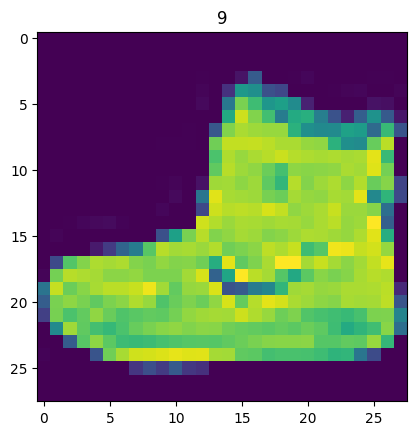

In [110]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) # We squeeze this because matplotlib either takes color channels first or something like that, check documentation for more information
plt.title(label)

Text(0.5, 1.0, 'Ankle boot')

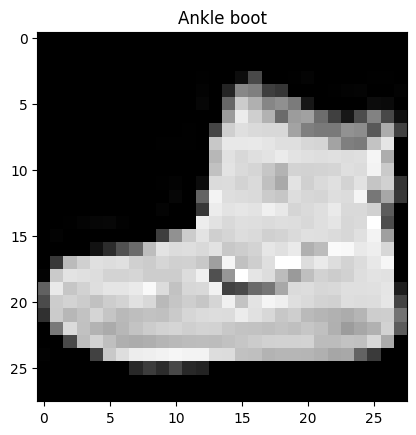

In [111]:
# plotting this in gray scale
plt.imshow(image.squeeze(), cmap = "gray")
plt.title(class_names[label])

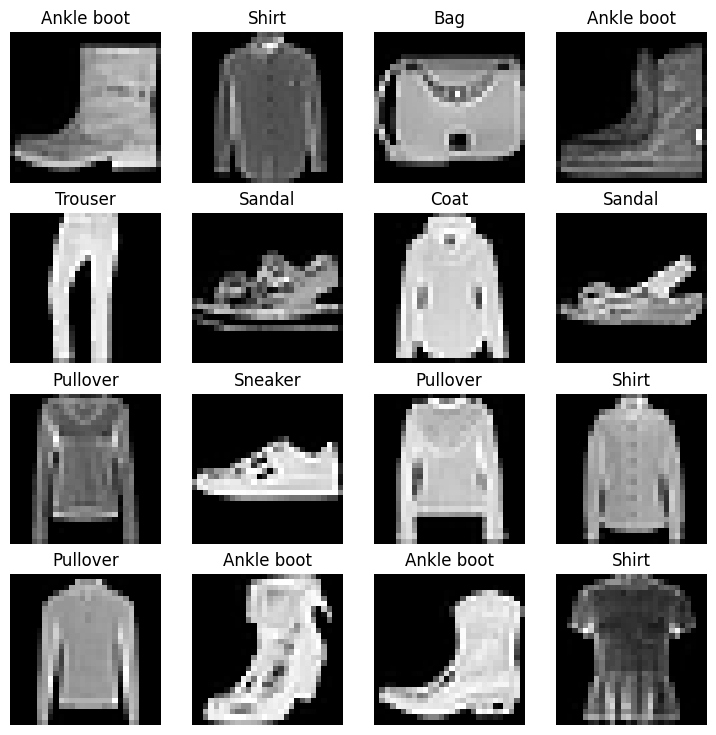

In [112]:
# Plot more images 
torch.manual_seed(42)
fig = plt.figure(figsize = (9,9))
rows, cols = 4, 4 
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size = [1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

These items of clothing images will probably need non-linear lines since some of these clothing items can easily be classified as each other e.g T-shirt vs shirt vs top... etc. 


In [113]:
train_data, test_data 

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

### Prepare DataLoader 

Right now our data is in the form as a PyTorch Dataset. 
We want to turn our data into batches, or mini batches
DataLoader turns our dataset into a Python iterable. 

We do this:
1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memory) at 60000 images in one hit. So we break it down to 32 images at a time (batch size of 32)
2. It gives our NN more chances to update its gradients per epoch 


In [114]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32 

# Turn datasets in to iterables (batches)
train_dataloader = DataLoader(dataset = train_data, 
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data, 
                             batch_size = BATCH_SIZE, 
                             shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1f885f8c620>,
 <torch.utils.data.dataloader.DataLoader at 0x1f885db9cd0>)

In [115]:
# Print the attributes
print(f"DataLoaders: { train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001F885F8C620>, <torch.utils.data.dataloader.DataLoader object at 0x000001F885DB9CD0>)
Length of train_dataloader: 1875 batches of 32...
Length of test_dataloader: 313 batches of 32...


In [116]:
# Check out what's inside the training dataloader 
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 8, label size: torch.Size([])


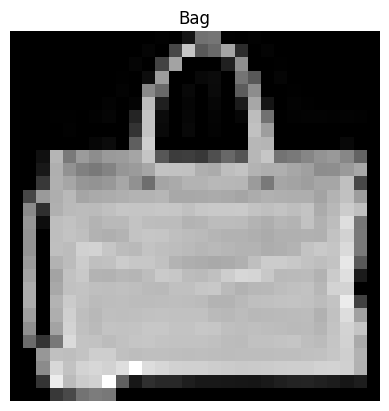

In [117]:
# Show a sample
# torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size = [1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap = "gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")


In [118]:
# File didn't save properly... lost the model and im too lazy to recode it
# Moving on to Convolutional Neural Networks 

## Model 2: Building a Convolutional Neural Network (CNN)

CNN's are also known as ConvNets 
CNN's are known for their capabilities to find patterns in visual data


In [125]:
# Create a convolutional neural network 
class FashionMNISTModelV2(nn.Module):
    """Model architecture that replicates the TinyVGG model from CNN explainer website"""
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units,
                      kernel_size = 3, 
                      stride = 1,
                      padding = 1), # these are the hyperparameters
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels= hidden_units,
                      kernel_size = 3,
                      stride = 1, 
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units, 
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units, 
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units*0,
                      out_features = output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        print(x.shape)
        x = self.conv_block_2(x)
        print(x.shape)
        x = self.classifier(x)
        return x


In [126]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape = 1,
                              hidden_units= 10, 
                              output_shape=len(class_names)).to(device)

c:\Users\AJITH\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


### Stepping through `nn.Conv2d()`

In [129]:
torch.manual_seed(42)

# Create a batch of images 
images = torch.randn(size=(32,3,64,64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])


In [134]:
# Create a single conv2d layer
torch.manual_seed(42)
conv_layer = nn.Conv2d(in_channels = 3, 
                       out_channels = 10,
                       kernel_size = (3,3),
                       stride = 1,
                       padding = 1)

# Pass the data through the convolutional layer
conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([10, 64, 64])

### Stepping through `nn.MaxPool2d()`

In [135]:
test_image.shape

torch.Size([3, 64, 64])

In [137]:
# print out original image shape without unsqueezed dimension 
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(0).shape}")

# Create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size = 2)

# Pass data through just the conv layer first
test_image_through_conv = conv_layer(test_image.unsqueeze(dim = 0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 64, 64])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 32, 32])


In [139]:
torch.manual_seed(42)
# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1,1,2,2))
print(f"\nRandom tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n {max_pool_tensor}")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")
random_tensor


Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
 tensor([[[[0.3367]]]])
Max pool tensor shape: torch.Size([1, 1, 1, 1])


tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])